## Physionet filtered data exploration

In [7]:
import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import sys
import json
import glob
from lib import utils

sys.path.append(os.getcwd()) 
sns.set(style='whitegrid')
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

from lib.plot_utils import read_loss_file,prepare_df_for_plotting, get_summary_lambdas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
result_json = glob.glob(f"../results_physionet_filtered/**/federated_training/**/**/**/results.json", recursive=True)
result_json = list(set(result_json))
result_json

['../results_physionet_filtered/physionet_filtered/federated_training/FedODE/10_rounds/rep_1-alpha_1.0-lr_0.001-batchsize_64_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_1.0/federated_outputs/results.json',
 '../results_physionet_filtered/physionet_filtered/federated_training/FedODE/10_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_64_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.5/federated_outputs/results.json',
 '../results_physionet_filtered/physionet_filtered/federated_training/FedODE/10_rounds/rep_1-alpha_0.0-lr_0.001-batchsize_64_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.0/federated_outputs/results.json']

In [8]:
df_centralized_evaluate = pd.DataFrame()
df_federated_evaluate = pd.DataFrame()
df_aggregation = pd.DataFrame()
for file in result_json:
    df_centralized_evaluate_temp, df_federated_evaluate_temp, df_aggregation_temp = read_loss_file(file)
    df_centralized_evaluate = pd.concat([df_centralized_evaluate, df_centralized_evaluate_temp])
    df_federated_evaluate = pd.concat([df_federated_evaluate, df_federated_evaluate_temp])
    df_aggregation = pd.concat([df_aggregation, df_aggregation_temp])
df = pd.concat([df_centralized_evaluate, df_federated_evaluate])
df_summary_lambdas = get_summary_lambdas(df_aggregation)

<Figure size 1000x300 with 0 Axes>

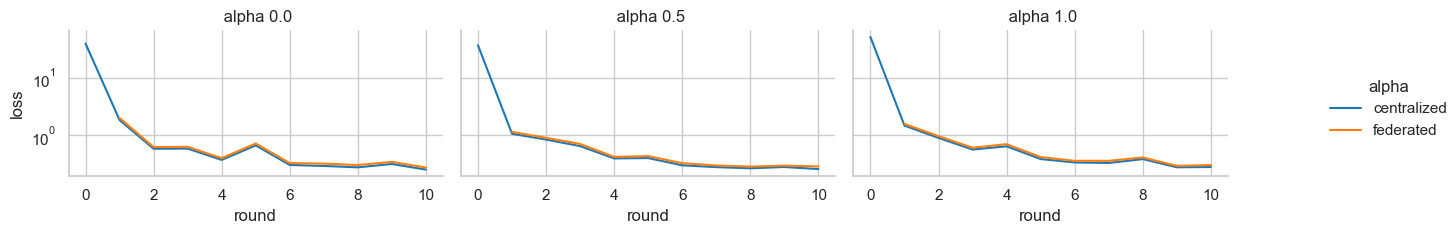

In [9]:
loss_df = df[df['type'].isin(["centralized", "federated"])]


# fig size
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    loss_df,
    col="alpha",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='round',
    y='loss',
    hue='type',
    palette='tab10'
)

# Adjustments
g.set_axis_labels("round", "loss")
g.set_titles(" alpha {col_name}")
#g.set(ylim=(0, None))

# Move legend outside
g.add_legend(title ="alpha")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# y axis log

plt.yscale('log')

plt.tight_layout()
plt.show()

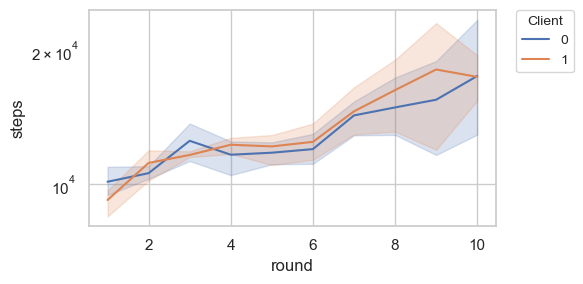

In [10]:
######################################
#  Plot the last loss vs difference
#######################################
plt.figure(figsize=(6, 3))
#df_summary_lambdas = df_summary_lambdas[df_summary_lambdas["alpha"]== 0.0]
sns.lineplot(data=df_summary_lambdas, x='round', y='steps',
             hue='client',  markers=True, dashes=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
           borderaxespad=0., title='Client', fontsize='small', title_fontsize='small')

plt.tight_layout()
# make y axis log scale
plt.yscale('log')
plt.show()